In [16]:
import  matplotlib.pyplot as plt
import numpy as np 


import seaborn as sns
from global_land_mask import globe

from scipy import interpolate



from netCDF4 import Dataset

import tensorflow as tf


# Data Analysis

Historical Climate Observation and Stimulation Dataset is provided by Institute for Climate and Application Research(ICAR). \
There is historical stimulation data by CMIP5/6 mode and historical assimilated observation data by American SODA mode in nearly 100 years. \
Each sample contains the following meteorological and spatiotemporal variables: \
SST (SST), Heat Content Anomaly (T300) (T300), Zonal Wind Anomaly (Ua), and Meridional Wind Anomaly (Va). \
The data dimensions are (year,month, Lat, Lon). For the training data, the Nino3.4 Index tag data of the corresponding month shall be provided.

In [17]:
cmip_train = Dataset('/Users/sunjie/TIANCHI/data/CMIP_train.nc')
cmip_label = Dataset('/Users/sunjie/TIANCHI/data/CMIP_label.nc')
soda_train = Dataset('/Users/sunjie/TIANCHI/data/SODA_train.nc')
soda_label = Dataset('/Users/sunjie/TIANCHI/data/SODA_label.nc')

The dimensions of soda_label are 2, they are year and month, the size of 2 dimensions are 100 and 36 separately

In [18]:
soda_label

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): year(100), month(36)
    variables(dimensions): float64 nino(year, month), int32 year(year), int32 month(month)
    groups: 

# Temporal 

In [19]:
soda_label= soda_label['nino']

In [20]:
mode_soda=[]
for i in range(0,len(soda_label),100):
    mode_soda.append(soda_label[i:i+100])

In [21]:
soda_label =[soda_label[0]] + [soda_label[i, 24:] for i in range(1, soda_label.shape[0])]

In [22]:
soda_label = np.concatenate(soda_label,axis=0)
soda_label.shape

(1224,)

Label data of CMIP (SODA)_train.nc is sliding mean of Nino3.4 SST’s current abnormal index in 3 months, and the El Niño events identified using 0.5°C threshold, the blue line means value within .5°C,vice versa.

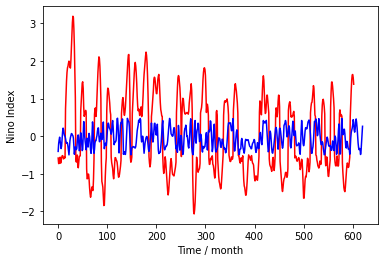

In [23]:
nino_label = soda_label.copy()
non_nino_label = soda_label.copy()

#nino_label[nino_label >= abs(0.5)] = np.nan
#non_nino_label[non_nino_label < abs(0.5)] 

#plt.style.use('fivethirtyeight')
plt.plot(nino_label[abs(nino_label) >= 0.5], color='r')
plt.plot(non_nino_label[abs(non_nino_label) < 0.5], color='b')

plt.xlabel('Time / month')
plt.ylabel('Nino Index')
plt.show()

From 1- 2265 samples, there are 15 simulation data under cmip6 mode, thus I plot each simulation separately.          

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

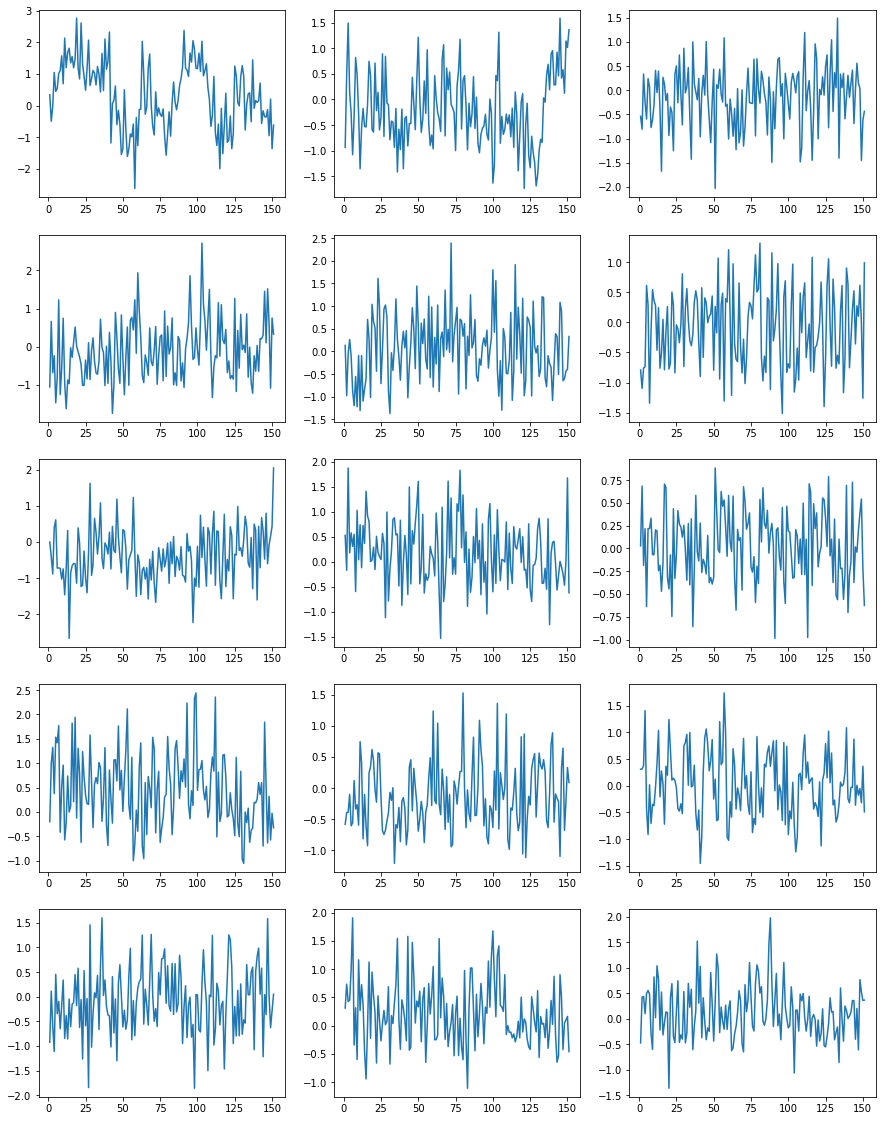

In [24]:
sst = cmip_train['sst']
sst_cmip6=sst[0:2265,0,0,0]
mode_15=[]
for i in range(0,len(sst_cmip6),151):
    mode_15.append(sst_cmip6[i:i+151])
    

plt.figure(figsize=(15, 20))
for i in range(15):
    plt.subplot(5,3,i+1)
    plt.plot(list(range(1,151+1)),mode_15[i])

plt.tight_layout

Same process for cmip5.

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

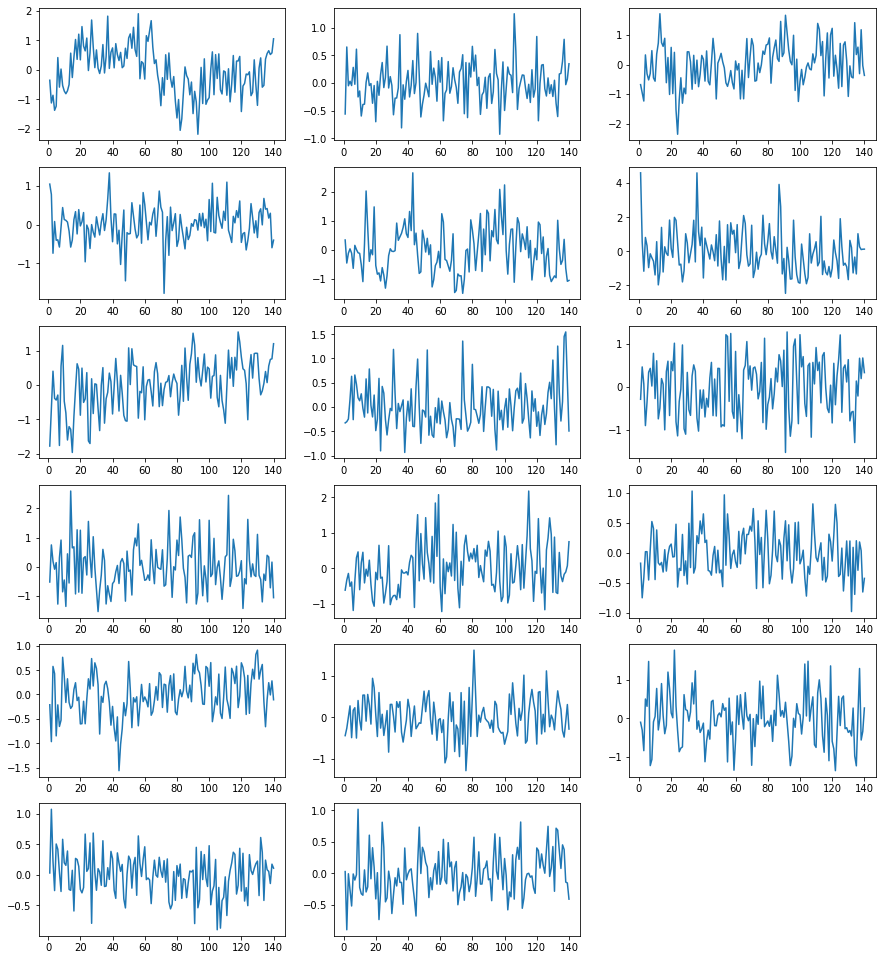

In [25]:

sst_cmip5=sst[2265:,0,0,0]
mode_17=[]
for i in range(0,len(sst_cmip5),140):
    mode_17.append(sst_cmip5[i:i+140])
    

plt.figure(figsize=(15, 20))
for i in range(17):
    plt.subplot(7,3,i+1)
    plt.plot(list(range(1,140+1)),mode_17[i])

plt.tight_layout

# Spatio

In [26]:

lon = np.array(soda_train.variables['lon'])
lat = np.array(soda_train.variables['lat'])
#x = lon
#y = lat
lonl,latl  = np.meshgrid(lon, lat)
z = soda_train.variables['sst'][0,0]
f = interpolate.interp2d(lon, lat, z, kind='cubic')

In [27]:
z.data

array([[ 1.8618509 ,  2.6930773 ,  2.0068998 , ...,  1.749043  ,
         1.6889814 ,  1.6952012 ],
       [ 1.1124177 ,  1.6091517 ,  1.6938334 , ...,  1.3404628 ,
         1.4752474 ,  1.5027997 ],
       [ 1.2253761 ,  1.2931638 ,  1.520402  , ...,  0.42051327,
         1.1427035 ,  1.2884156 ],
       ...,
       [-1.3888688 , -0.38025168,  0.        , ..., -1.8572958 ,
        -1.9819403 , -1.589553  ],
       [-1.0395981 , -1.9604764 , -1.8086063 , ..., -1.9639194 ,
        -1.665546  , -1.3774221 ],
       [-0.80945176, -1.0251031 , -0.8664182 , ..., -1.6170758 ,
        -1.3439701 , -1.3997539 ]], dtype=float32)

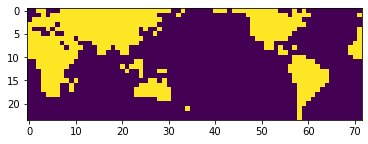

In [24]:
lon_grid, lat_grid = np.meshgrid(lon-180, lat)
# Check if a point is on land:
is_on_land = globe.is_land(lat_grid, lon_grid)
is_on_land = np.concatenate([is_on_land[:,lon>=180], is_on_land[:,lon<180]], axis=1)
z[is_on_land] = np.nan
plt.imshow(is_on_land[::-1,:])

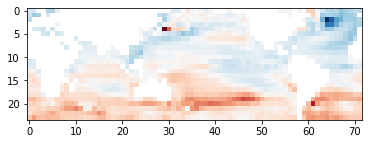

In [25]:
plt.imshow(z[::-1,:], cmap=plt.cm.RdBu_r)

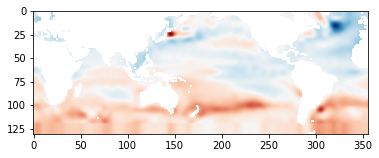

In [26]:
lon_new = np.arange(0,356,1)
lat_new = np.arange(-65,66,1)
z_new = f(lon_new, lat_new)

lon_grid, lat_grid = np.meshgrid(lon_new-180, lat_new)
# Check if a point is on land:
is_on_land = globe.is_land(lat_grid, lon_grid)
is_on_land = np.concatenate([is_on_land[:,lon_new>=180], is_on_land[:,lon_new<180]], axis=1)
z_new[is_on_land] = np.nan
plt.imshow(z_new[::-1,:], cmap=plt.cm.RdBu_r)#is_on_land[:,:])

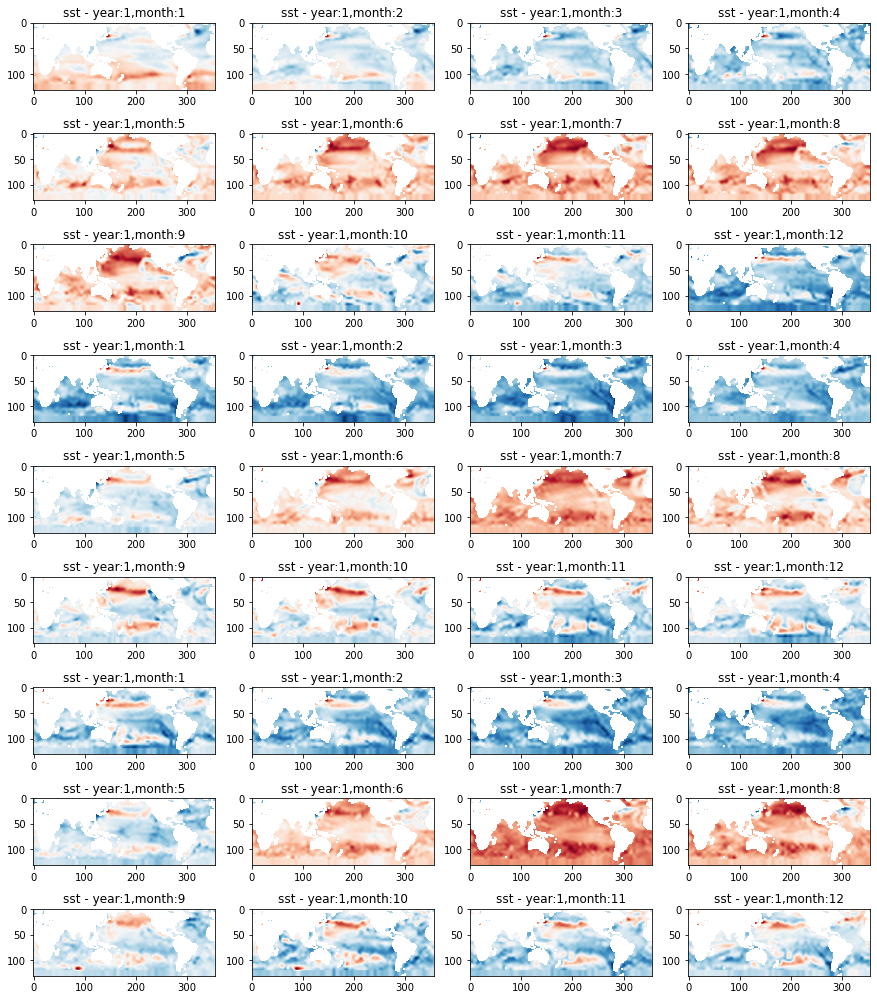

In [29]:
#plt.figure(figsize=(15,18))
for i in range(1):
    plt.figure(figsize=(15,18))
    for j in range(36):
        x = lon
        y = lat
        lonl, latl = np.meshgrid(x, y)
        z = soda_train.variables['sst'][i,j]#某一年某一月sst的分布值
        f = interpolate.interp2d(x, y, z, kind='cubic')

        xnew = np.arange(0,356,1)
        ynew = np.arange(-65,66,1)
        znew = f(xnew, ynew)

        lon_grid, lat_grid = np.meshgrid(xnew-180, ynew)
        # Check if a point is on land:
        is_on_land = globe.is_land(lat_grid, lon_grid)
        is_on_land = np.concatenate([is_on_land[:,xnew>=180], is_on_land[:,xnew<180]], axis=1)
        znew[is_on_land] = np.nan
        #plt.figure()
        plt.subplot(9,4,j+1)
        plt.imshow(znew[::-1,:], cmap=plt.cm.RdBu_r)#is_on_land[:,:])
        plt.title('sst - year:{},month:{}'.format(i+1,(j)%12+1))

# Analysis of Nan Number

In [31]:
path = '/Users/sunjie/TIANCHI/data/'
data = Dataset(path+'CMIP_train.nc') 
label = Dataset(path+'CMIP_label.nc')
label = np.array(label.variables['nino'])

In [32]:
lon_grid, lat_grid = np.meshgrid(x-180, y)
is_on_land = globe.is_land(lat_grid, lon_grid)
is_on_land = np.concatenate([is_on_land[:,x>=180], is_on_land[:,x<180]], axis=1)
mask = np.zeros(data.variables['t300'].shape, dtype=int)
mask[:,:,:,:] = is_on_land[np.newaxis,np.newaxis,:,:]

In [33]:
name = 'va'
data_ = np.array(data.variables[name])
before_nan = np.sum(np.isnan(data_))
print('before:', before_nan)

before: 13921123


In [34]:
data_.shape

(4645, 36, 24, 72)

In [35]:
m = np.zeros(data_.shape[0:2])
for i in range(data_.shape[0]):
    for j in range(data_.shape[1]):
        if np.sum(np.isnan(data_[i,j])) != 0:
            m[i, j] = np.sum(np.isnan(data_[i,j]))

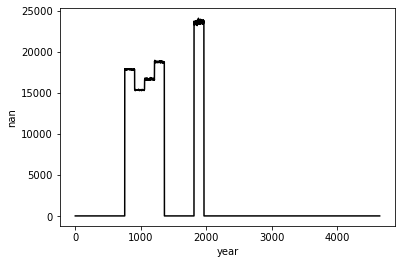

In [36]:
#sum every year's missing value (4645, 36）->  (4645,1)
before = np.sum(m, axis=1)
plt.plot(before, 'k')
plt.ylabel('nan')
plt.xlabel('year')
plt.show()

In [37]:
#sst missing list   0 
len(np.where(before!=0)[0])

755

In [38]:
#va missing 13921123
len(np.where(before!=0)[0])

755

In [39]:
#t300 missing list   3055032
len(np.where(before!=0)[0])

755

In [40]:
SODA_train_sst=np.random.random((100,12,24,72))
SODA_label_nino = np.random.random((100,24))

SODA_train_sst.shape
SODA_label_nino.shape


m = np.zeros(SODA_train_sst.shape[0])
for i in range(SODA_train_sst.shape[0]):
    if np.sum(np.isnan(SODA_train_sst[i])) != 0:
        m[i] = np.sum(np.isnan(SODA_train_sst[i]))
        
        
m[1] = 10

m

# remove data which with missing value, and choose data with 0 nah value
SODA_label_nino = SODA_label_nino[np.where(m==0)[0]]
SODA_train_sst = SODA_train_sst[np.where(m==0)[0]]

np.where(m==0)[0]

SODA_label_nino.shape

SODA_train_sst.shape

(99, 12, 24, 72)

In [41]:
m = np.zeros(SODA_train_sst.shape[0])
for i in range(SODA_train_sst.shape[0]):
    if np.sum(np.isnan(SODA_train_sst[i])) != 0:
        m[i] = np.sum(np.isnan(SODA_train_sst[i]))
        
# remove data which with missing value, and choose data with 0 nah value
SODA_label_nino = SODA_label_nino[np.where(m==0)[0]]
SODA_train_sst = SODA_train_sst[np.where(m==0)[0]]

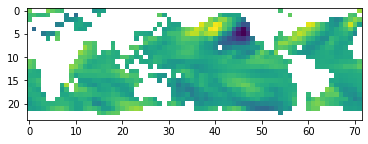

In [42]:
plt.imshow(data_[1900,0][::-1,:])

In [43]:
#fix land with zero
data_[mask==1] = 0

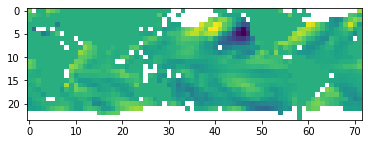

In [44]:
plt.imshow(data_[1900,0][::-1,:])

In [45]:
after_nan = np.sum(np.isnan(data_))

In [46]:
print('before:%d\nafter:%d\npercentage:%f'%(before_nan, after_nan, 1-float(after_nan)/before_nan))

before:13921123
after:2440742
percentage:0.824673


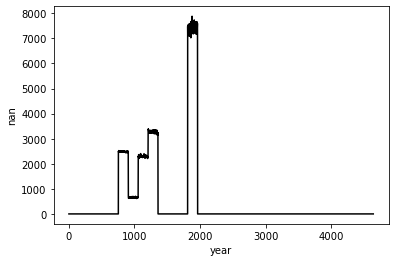

In [47]:
m = np.zeros(data_.shape[0:2])
for i in range(data_.shape[0]):
    for j in range(data_.shape[1]):
        if np.sum(np.isnan(data_[i,j])) != 0:
            m[i, j] = np.sum(np.isnan(data_[i,j]))
after = np.sum(m, axis=1)
plt.plot(after, 'k')
plt.ylabel('nan')
plt.xlabel('year')
plt.show()

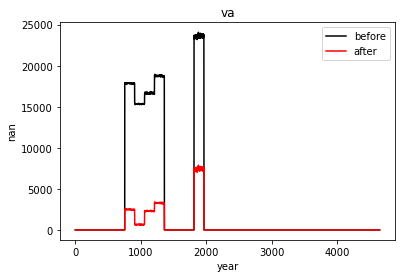

In [48]:
plt.plot(before, 'k')
plt.plot(after, 'r')
plt.legend(['before', 'after'])
plt.title(name)
plt.ylabel('nan')
plt.xlabel('year')
plt.show()

In [1]:
import torch
import torch.nn as nn 
import numpy as np

In [2]:
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.
        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias).to(device)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next.to(device), c_next.to(device)

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

class ConvLSTM(nn.Module):

    """
    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.
    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        #self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]
            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

        self.liner = nn.Linear(16*24*72,24)
    def forward(self, input_tensor, hidden_state=None):
        """
        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful
        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()
        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):
            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])
        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [3]:
device = 'cpu'
#(batch  seq_len  channel h,w)
x = torch.rand((32, 10, 64, 128, 128))
y = torch.rand((32, 10, 16, 128, 128))


# input_channel=64  hidden_dim=16  ker=3 ,numlayers = 1   batchfirst =True  bias=True  return_all_layers=False
convlstm = ConvLSTM(64, 16, (3,3), 1, True, True, False)
out, last_states = convlstm(x)

# out (32, 10, 16, 128, 128)  (batch  seq_len  channel h,w)   
# last_states(32,16,128,128)
h = last_states[0][0]  # 0 for layer index, 0 for h index   h0 c0
print('h_state:',h.shape)
print('input:',x.shape)
print('out:',out[0].shape)  #0 for layer index

h_state: torch.Size([32, 16, 128, 128])
input: torch.Size([32, 10, 64, 128, 128])
out: torch.Size([32, 10, 16, 128, 128])


In [4]:
lr = 1e-1       # learning rate
max_epoch = 2  # number of epochs

# set manual seed
torch.manual_seed(0)

print('Instantiate model')
device = 'cpu'
# input_channel=64  hidden_dim=16  ker=3 ,numlayers = 1   batchfirst =True  bias=True  return_all_layers=False
model = ConvLSTM(12, 16, (3,3), 1, True, True, False)
print(repr(model))

print('Create input and target Variables')
# x = batch  seq_len  channel h,w
x = torch.rand((32, 10, 12, 24, 72))
y = torch.rand((32,10,16,24,72))


print('Create a MSE criterion')
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

print('Run for', max_epoch, 'iterations')
for epoch in range(0, max_epoch):
    model.train()
    optimizer.zero_grad()
    out,h = model(x)
    print(out[0].shape)
    loss = loss_fn(out[0],y)
    print(' > Epoch {:2d} loss: {:.3f}'.format((epoch+1), loss.item()))
    loss.backward()
    optimizer.step()

print('Input size:', list(x.size()))
print('Target size:', list(y.size()))
print('Last hidden state size:', list(h[0][0].size()))


Instantiate model
ConvLSTM(
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(28, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (liner): Linear(in_features=27648, out_features=24, bias=True)
)
Create input and target Variables
Create a MSE criterion
Run for 2 iterations
torch.Size([32, 10, 16, 24, 72])
 > Epoch  1 loss: 0.325
torch.Size([32, 10, 16, 24, 72])
 > Epoch  2 loss: 0.324
Input size: [32, 10, 12, 24, 72]
Target size: [32, 10, 16, 24, 72]
Last hidden state size: [32, 16, 24, 72]


# CNN+LSTM

In [5]:
import os
import torch
from copy import deepcopy
import numpy as np
import xarray as xr
import pandas as pd
import torch.nn as nn
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import zipfile
import torchvision.models as models

In [6]:
def set_seed(seed = 123):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)


def load_data2():
    # CMIP data    
    #PATH = './tcdata/enso_round1_train_20210201/'
    #PATH = 'E:/enso_round1_train_20210201/'
    PATH = '/Users/sunjie/TIANCHI/data/'
    train = xr.open_dataset(PATH+'CMIP_train.nc')
    label = xr.open_dataset(PATH+'CMIP_label.nc')  
   
    train_sst = train['sst'][:, :12].values  # (4645, 12, 24, 72)
    train_t300 = train['t300'][:, :12].values
    train_ua = train['ua'][:, :12].values
    train_va = train['va'][:, :12].values
    train_label = label['nino'][:, 12:36].values
    
    m = np.zeros(train_ua.shape[0])
    for i in range(train_ua.shape[0]):
        if np.sum(np.isnan(train_ua[i])) != 0:
            m[i] = np.sum(np.isnan(train_ua[i]))

    #将有缺失值的数据 剔除，选择缺失值为0的数据
    train_sst = train_sst[np.where(m==0)[0]]
    train_t300 = train_t300[np.where(m==0)[0]]
    train_ua = train_ua[np.where(m==0)[0]]
    train_va = train_va[np.where(m==0)[0]]
    train_label = train_label[np.where(m==0)[0]]

    N = int(len(train_label)*0.8)
    print('Train samples: {}, Valid samples: {}'.format(len(train_label[:N]), len(train_label[N:])))

    dict_train = {
        'sst':train_sst[:N],
        't300':train_t300[:N],
        'ua':train_ua[:N],
        'va': train_va[:N],
        'label': train_label[:N]}
    dict_valid = {
        'sst':train_sst[N:],
        't300':train_t300[N:],
        'ua':train_ua[N:],
        'va': train_va[N:],
        'label': train_label[N:]}
    
    train_dataset = EarthDataSet(dict_train)
    valid_dataset = EarthDataSet(dict_valid)
    return train_dataset, valid_dataset
    

In [8]:
class EarthDataSet(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data['sst'])

    def __getitem__(self, idx):   
        return (self.data['sst'][idx], self.data['t300'][idx], self.data['ua'][idx], 
                self.data['va'][idx]), self.data['label'][idx]

In [9]:

class simpleSpatailTimeNN(nn.Module):
    def __init__(self, n_cnn_layer:int=1, kernals:list=[3], n_lstm_units:int=64):
        super(simpleSpatailTimeNN, self).__init__()
        self.conv1 = nn.ModuleList([nn.Conv2d(in_channels=12, out_channels=12, kernel_size=i) for i in kernals]) 
        self.conv2 = nn.ModuleList([nn.Conv2d(in_channels=12, out_channels=12, kernel_size=i) for i in kernals])
        self.conv3 = nn.ModuleList([nn.Conv2d(in_channels=12, out_channels=12, kernel_size=i) for i in kernals])
        self.conv4 = nn.ModuleList([nn.Conv2d(in_channels=12, out_channels=12, kernel_size=i) for i in kernals])
        self.pool1 = nn.AdaptiveAvgPool2d((22, 1))
        self.pool2 = nn.AdaptiveAvgPool2d((1, 70))
        self.pool3 = nn.AdaptiveAvgPool2d((1, 128))
        self.batch_norm = nn.BatchNorm1d(12, affine=False)
        self.lstm = nn.LSTM(22*70 * 4, n_lstm_units, 2, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(128, 24)

    def forward(self, sst, t300, ua, va):
        for conv1 in self.conv1:
            sst = conv1(sst)  # batch * 12 * (24 - 2) * (72 -2)
        for conv2 in self.conv2:
            t300 = conv2(t300)
        for conv3 in self.conv3:
            ua = conv3(ua)
        for conv4 in self.conv4:
            va = conv4(va)

        sst = torch.flatten(sst, start_dim=2)  # batch * 12 * 1540
        t300 = torch.flatten(t300, start_dim=2)
        ua = torch.flatten(ua, start_dim=2)
        va = torch.flatten(va, start_dim=2)  # if flat, lstm input_dims = 1540 * 4              
            
        x = torch.cat([sst, t300, ua, va], dim=-1)    
        x = self.batch_norm(x)
        x, _ = self.lstm(x)
        x = self.pool3(x).squeeze(dim=-2)
        x = self.linear(x)
        return x

In [10]:
def coreff(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    c1 = sum((x - x_mean) * (y - y_mean))
    c2 = sum((x - x_mean)**2) * sum((y - y_mean)**2)
    return c1/np.sqrt(c2)

def rmse(preds, y):
    return np.sqrt(sum((preds - y)**2)/preds.shape[0])

def eval_score(preds, label):
    # preds = preds.cpu().detach().numpy().squeeze()
    # label = label.cpu().detach().numpy().squeeze()
    acskill = 0
    RMSE = 0
    a = 0
    a = [1.5]*4 + [2]*7 + [3]*7 + [4]*6
    for i in range(24):
        RMSE += rmse(label[:, i], preds[:, i])
        cor = coreff(label[:, i], preds[:, i])
    
        acskill += a[i] * np.log(i+1) * cor
    return 2/3 * acskill - RMSE

In [49]:
def train():
    fit_params = {
    'n_epochs' : 10,
    'learning_rate' : 0.0001,
    'batch_size' : 100,}

    set_seed()
    best_sco = -1000
    train_dataset, valid_dataset = load_data2()      
    train_loader = DataLoader(train_dataset, batch_size=fit_params['batch_size'])
    valid_loader = DataLoader(valid_dataset, batch_size=fit_params['batch_size'])
    best_sco = -1000
    model = simpleSpatailTimeNN()
    device = 'cpu'
    optimizer = torch.optim.Adam(model.parameters(), lr=fit_params['learning_rate'])
    loss_fn = nn.MSELoss()   
    
    model.to(device)
    loss_fn.to(device)

    for i in range(fit_params['n_epochs']):
        model.train()
        for step, ((sst, t300, ua, va), label) in enumerate(train_loader): 
            #print(sst.shape)
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            optimizer.zero_grad()
            label = label.to(device).float()
            #print(sst.shape)
            preds = model(sst,t300,ua,va)
            loss = loss_fn(preds, label)
            loss.backward()
            optimizer.step()
            #print('Step: {}, Train Loss: {}'.format(step, loss))
            
        model.eval()
        y_true, y_pred = [], []
        for step, ((sst, t300, ua, va), label) in enumerate(train_loader):
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            label = label.to(device).float()
            preds = model(sst,t300,ua,va)

            y_pred.append(preds)
            y_true.append(label)

        y_true = torch.cat(y_true, axis=0)
        y_pred = torch.cat(y_pred, axis=0)
        score = eval_score(y_true.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
        ls = loss_fn(y_pred,y_true).cpu().detach().numpy()
        print("Epoch: {} Train acc: {}  Train loss: {}".format(i+1,round(score,2),ls))
        
#         model.eval()
        y_true, y_pred = [], []
        for step, ((sst, t300, ua, va), label) in enumerate(valid_loader):
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            label = label.to(device).float()
            preds = model(sst,t300,ua,va)

            y_pred.append(preds)
            y_true.append(label)

        y_true = torch.cat(y_true, axis=0)
        y_pred = torch.cat(y_pred, axis=0)
        score = eval_score(y_true.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
        ls = loss_fn(y_pred,y_true).cpu().detach().numpy()
        print("Epoch: {} Test acc: {}   Test loss: {}".format(i+1,round(score,2),ls))
        
        if score>best_sco:
            best_sco = score
            PATH = '/Users/sunjie/TIANCHI/data/retrainref.pt'
            torch.save(model.state_dict(), PATH)
            #torch.save(model, './user_data/ref.pkl')
            print('Model saved successfully')

In [12]:
def load_data2_SODA(ratio = 0.8):  
    # CMIP data    
    #PATH = './tcdata/enso_round1_train_20210201/'
    #PATH = 'E:/enso_round1_train_20210201/'
    PATH = './data/'
    train2 = xr.open_dataset(PATH+'SODA_train.nc')
    label2 = xr.open_dataset(PATH+'SODA_label.nc')  
    train_sst2 = train2['sst'][:, :12].values  # (4645, 12, 24, 72)
    train_t3002 = train2['t300'][:, :12].values
    train_ua2 = train2['ua'][:, :12].values
    train_va2 = train2['va'][:, :12].values
    train_label2 = label2['nino'][:, 12:36].values
    
    m = np.zeros(train_ua2.shape[0])
    for i in range(train_ua2.shape[0]):
        if np.sum(np.isnan(train_ua2[i])) != 0:
            m[i] = np.sum(np.isnan(train_ua2[i]))

    #将有缺失值的数据 剔除，选择缺失值为0的数据
    train_sst2 = train_sst2[np.where(m==0)[0]]
    train_t3002 = train_t3002[np.where(m==0)[0]]
    train_ua2 = train_ua2[np.where(m==0)[0]]
    train_va2 = train_va2[np.where(m==0)[0]]
    train_label2 = train_label2[np.where(m==0)[0]]
    
    
    #测试集比例变动对其结果影响很大！
    N = int(len(train_sst2)* ratio)
    print('Train samples: {}, Valid samples: {}'.format(len(train_label2[:N]), len(train_label2[N:])))
    
    dict_train = {
        'sst':     train_sst2[2:N],
        't300':   train_t3002[2:N],
        'ua':       train_ua2[2:N],
        'va':       train_va2[2:N],
        'label': train_label2[2:N]}
    dict_valid = {
        'sst':     train_sst2[N:],
        't300':   train_t3002[N:],
        'ua':       train_ua2[N:],
        'va':       train_va2[N:],
        'label': train_label2[N:]}
    
    train_dataset = EarthDataSet(dict_train)
    valid_dataset = EarthDataSet(dict_valid)
    return train_dataset, valid_dataset


In [50]:
def retrain():
    set_seed()
    best_sco = -1000
    fit_params = {
        'n_epochs' : 22,
        'learning_rate' : 0.00005,
        'batch_size' : 100,
    }
    
    train_dataset, valid_dataset = load_data2_SODA()      
    train_loader = DataLoader(train_dataset, batch_size=fit_params['batch_size'])
    valid_loader = DataLoader(valid_dataset, batch_size=fit_params['batch_size'])
    
    # Specify a path
    PATH = '/Users/sunjie/TIANCHI/data/retrainref.pt'
    # Load
    model = simpleSpatailTimeNN()
    model.load_state_dict(torch.load(PATH))
    device = 'cpu'
    optimizer = torch.optim.Adam(model.parameters(), lr=fit_params['learning_rate'])
    loss_fn = nn.MSELoss()   
    
    model.to(device)
    loss_fn.to(device)

    for i in range(fit_params['n_epochs']):
        model.train()
        for step, ((sst, t300, ua, va), label) in enumerate(train_loader): 
            #print(sst.shape)
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            optimizer.zero_grad()
            label = label.to(device).float()
            #print(sst.shape)
            preds = model(sst,t300,ua,va)
            loss = loss_fn(preds, label)
            loss.backward()
            optimizer.step()
            #print('Step: {}, Train Loss: {}'.format(step, loss))
            
        model.eval()
        y_true, y_pred = [], []
        for step, ((sst, t300, ua, va), label) in enumerate(train_loader):
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            label = label.to(device).float()
            preds = model(sst,t300,ua,va)

            y_pred.append(preds)
            y_true.append(label)

        y_true = torch.cat(y_true, axis=0)
        y_pred = torch.cat(y_pred, axis=0)
        score = eval_score(y_true.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
        ls = loss_fn(y_pred,y_true).cpu().detach().numpy()
        print("Epoch: {} Train acc: {}  Train loss: {}".format(i+1,round(score,2),ls))
        
#         model.eval()
        y_true, y_pred = [], []
        for step, ((sst, t300, ua, va), label) in enumerate(valid_loader):
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            label = label.to(device).float()
            preds = model(sst,t300,ua,va)

            y_pred.append(preds)
            y_true.append(label)

        y_true = torch.cat(y_true, axis=0)
        y_pred = torch.cat(y_pred, axis=0)
        score = eval_score(y_true.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
        ls = loss_fn(y_pred,y_true).cpu().detach().numpy()
        print("Epoch: {} Test acc: {}   Test loss: {}".format(i+1,round(score,2),ls))
        
        if score>best_sco:
            best_sco = score
            PATH = '/Users/sunjie/TIANCHI/data/ref.pt'
            torch.save(model.state_dict(), PATH)
            #torch.save(model, './user_data/ref.pkl')
            print('Model saved successfully')

In [51]:
train()
retrain()

Train samples: 3112, Valid samples: 778
Epoch: 1 Train acc: -7.99  Train loss: 0.6829771399497986
Epoch: 1 Test acc: -17.61   Test loss: 0.5815464854240417
Model saved successfully
Epoch: 2 Train acc: 6.61  Train loss: 0.6681841015815735
Epoch: 2 Test acc: -12.36   Test loss: 0.5785638093948364
Model saved successfully
Epoch: 3 Train acc: 21.97  Train loss: 0.6356195211410522
Epoch: 3 Test acc: 1.25   Test loss: 0.568675696849823
Model saved successfully
Epoch: 4 Train acc: 28.13  Train loss: 0.5825234055519104
Epoch: 4 Test acc: 13.49   Test loss: 0.5458896160125732
Model saved successfully
Epoch: 5 Train acc: 35.27  Train loss: 0.5311794877052307
Epoch: 5 Test acc: 21.82   Test loss: 0.5154002904891968
Model saved successfully
Epoch: 6 Train acc: 40.76  Train loss: 0.4816329777240753
Epoch: 6 Test acc: 26.28   Test loss: 0.48750823736190796
Model saved successfully
Epoch: 7 Train acc: 47.05  Train loss: 0.4348689615726471
Epoch: 7 Test acc: 28.63   Test loss: 0.46865618228912354
Mode